In [156]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import tensorflow as tf
import seaborn as sns

In [157]:
df = pd.read_csv('../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

In [158]:
from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [159]:
df.tail()

,deployment,t,t_increase,Vx,Vy,Vz,P,O2_S1,O2_S2,O2_S3,O2_avg
2017-07-17 05:59:59.500,3oec_2017_7_16_17,29.99987,50399.500,5.199,3.971,-0.747,82.820,245.689662,246.163399,247.119851,246.324304
2017-07-17 05:59:59.625,3oec_2017_7_16_17,29.99991,50399.625,7.785,4.487,-1.312,83.002,246.618662,245.778399,247.198851,246.531971
2017-07-17 05:59:59.750,3oec_2017_7_16_17,29.99994,50399.750,5.016,5.753,-0.937,82.895,247.084663,245.932399,246.413851,246.476971
2017-07-17 05:59:59.875,3oec_2017_7_16_17,29.99998,50399.875,5.304,2.982,-0.464,83.022,246.541663,246.548399,246.255851,246.448637
2017-07-17 06:00:00.000,3oec_2017_7_16_17,30.00001,50400.000,7.644,4.818,-1.115,82.723,245.880174,246.290942,247.116146,246.429087


In [160]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment', 't', 't_increase', 'Vx', 'Vy', 'Vz', 'P', 'O2_S1', 'O2_S2', 'O2_S3']).resample('5min').mean()

In [161]:
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [162]:
len(first_piece)

193

In [163]:
# Split the data into train, val, test (70-20-10)

column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(first_piece)
train_df =first_piece[0:int(n*0.7)]
val_df = first_piece[int(n*0.7):int(n*0.9)]
test_df = first_piece[int(n*0.9):]


In [164]:
len(test_df)

20

In [165]:
# Normalize the data (each partition separately)
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

/var/folders/d6/tw5j0wsn1m11p_w84_70527m0000gn/T/ipykernel_44501/2532475428.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(first_piece.keys(), rotation=90)


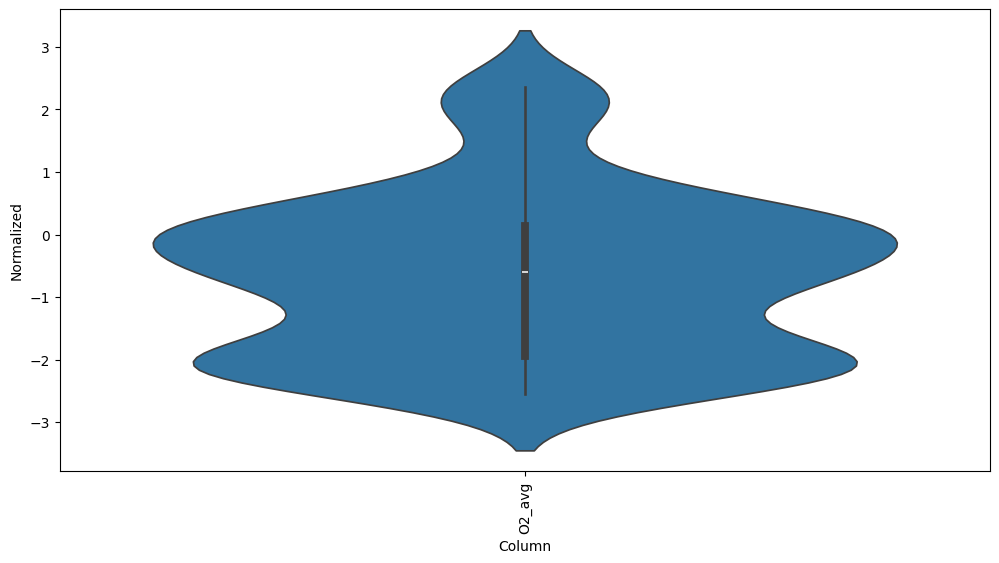

In [166]:
# Plot histogram
df_std = (first_piece - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(first_piece.keys(), rotation=90)

In [167]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
            return '\n'.join([
                f'Total window size : {self.total_window_size}',
                f'Input indices: {self.input_indices}',
                f'Label indices: {self.label_indices}',
                f'Label column name(s): {self.label_columns}'
            ])

In [168]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['O2_avg'])

In [169]:
print(w1)

Total window size : 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['O2_avg']


In [170]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['O2_avg'])
w2

Total window size : 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['O2_avg']

In [171]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns],
                          axis=-1)
        
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [172]:
len(train_df)

135

In [173]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[45:45+w2.total_window_size]),
                           np.array(train_df[90:90+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 1)
Inputs shape: (3, 6, 1)
Labels shape: (3, 1, 1)


In [174]:
w2.example = example_inputs, example_labels

In [175]:
# Now let's visualize the split window
def plot(self, model=None, plot_col='O2_avg', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12,8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)
        
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index
        
        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)
        
        if n == 0:
            plt.legend()
        
    plt.xlabel('Time [5min intervals]')

WindowGenerator.plot = plot

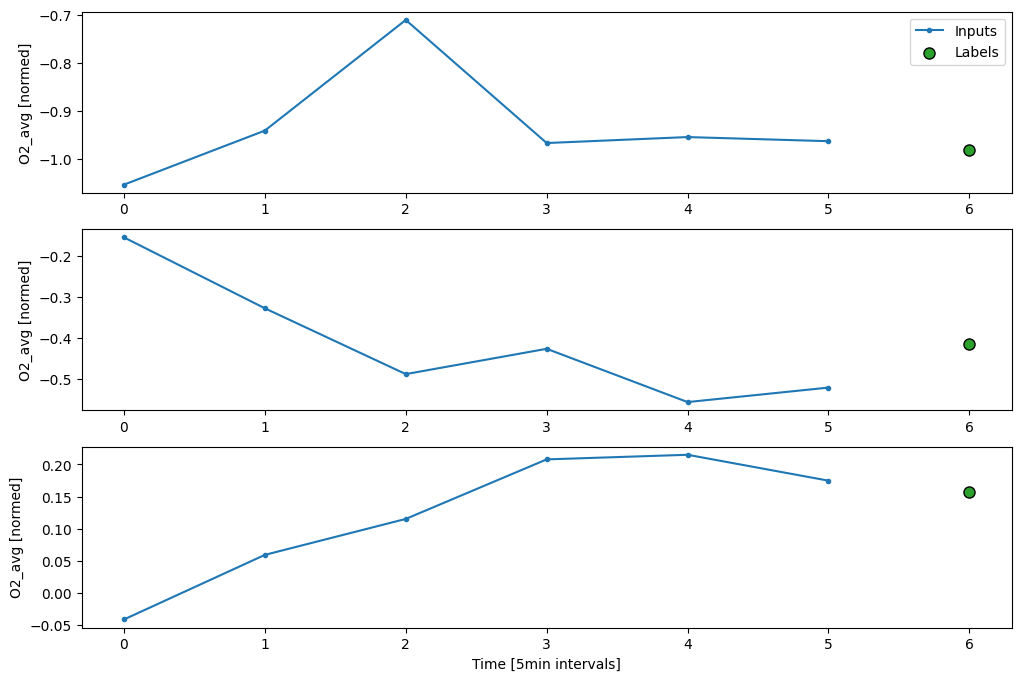

In [176]:
w2.plot()

In [177]:
# Now make a dataset using tf.data.Datasets
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=8
    )

    ds = ds.map(self.split_window)
    return ds

WindowGenerator.make_dataset = make_dataset

In [178]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of 'inputs, labels' for plotting"""
    result = getattr(self, '_example', None)
    if result is None:
        # No example btach was found, so get one from the '.train' dataset
        result = next(iter(self.train))
        # And cache it for the next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [179]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [180]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (8, 6, 1)
Labels shape (batch, time, features): (8, 1, 1)


2025-02-06 15:16:46.032462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [181]:
# Single step models
# Just playing around

# first create a single step window
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['O2_avg']
)
single_step_window

Total window size : 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['O2_avg']

In [182]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (8, 1, 1)
Labels shape (batch, time, features): (8, 1, 1)


2025-02-06 15:16:46.081991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [183]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [184]:
baseline = Baseline(label_index=column_indices['O2_avg'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - mean_absolute_error: 0.0484


In [185]:
wide_window = WindowGenerator(
    input_width=12, label_width=12, shift=1,
    label_columns=['O2_avg'])

wide_window

Total window size : 13
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Label column name(s): ['O2_avg']

In [186]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (8, 12, 1)
Output shape: (8, 12, 1)


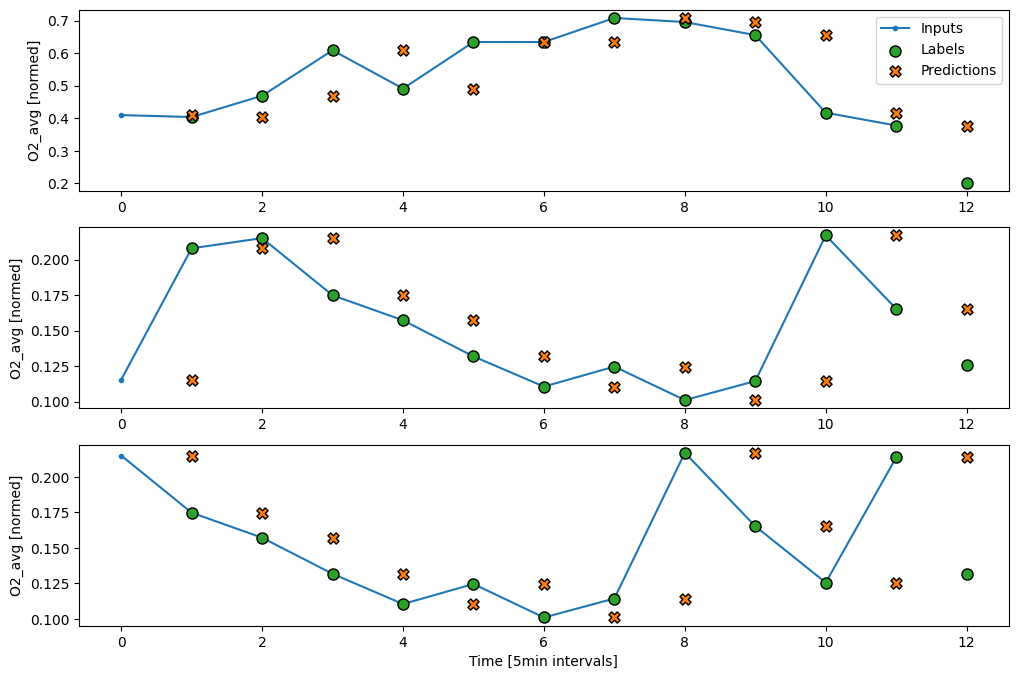

In [187]:
wide_window.plot(baseline)

In [188]:
# Now let's try LSTM
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(8, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [189]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (8, 12, 1)
Output shape: (8, 12, 1)


In [190]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [191]:
import IPython
import IPython.display

In [192]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8951 - mean_absolute_error: 0.9124


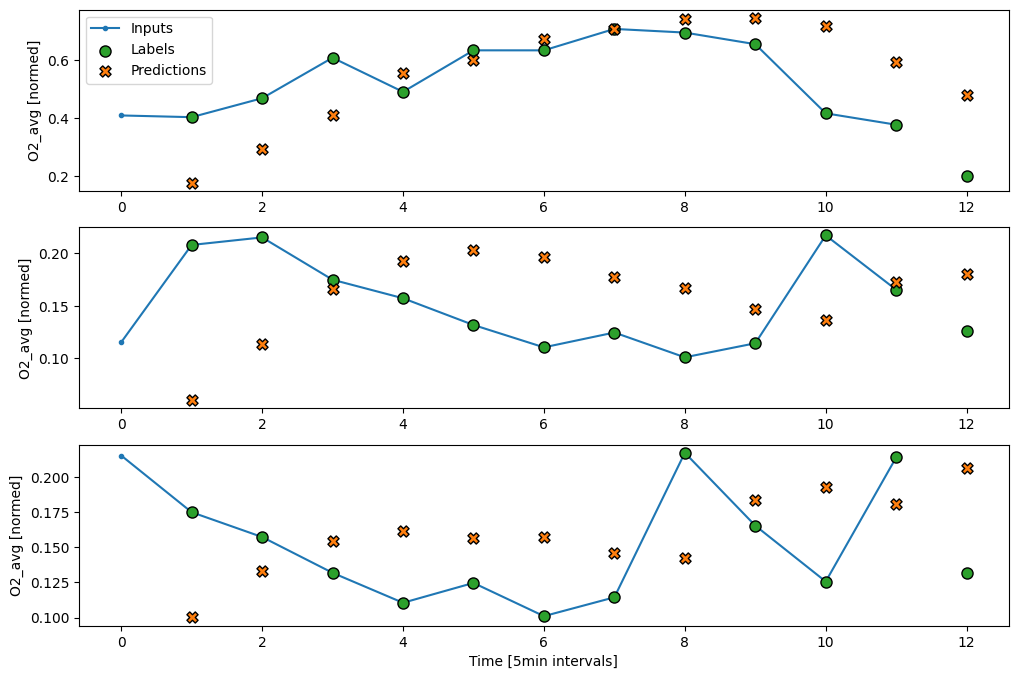

In [193]:
wide_window.plot(lstm_model)

In [194]:
wide_window.train_df

,O2_avg
2017-07-11 14:00:00,-1.054471
2017-07-11 14:05:00,-0.941558
2017-07-11 14:10:00,-0.710445
2017-07-11 14:15:00,-0.967509
2017-07-11 14:20:00,-0.955053
...,...
2017-07-12 00:50:00,-1.611856
2017-07-12 00:55:00,-1.649085
2017-07-12 01:00:00,-1.688419
2017-07-12 01:05:00,-1.674122


In [195]:
wide_window.test

<_MapDataset element_spec=(TensorSpec(shape=(None, 12, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 12, 1), dtype=tf.float32, name=None))>

In [205]:
one_batch = next(iter(wide_window.test))

In [210]:
one_batch[0][0]

<tf.Tensor: shape=(12, 1), dtype=float32, numpy=
array([[-2.3173528],
       [-2.3048513],
       [-2.334514 ],
       [-2.3856337],
       [-2.3916252],
       [-2.4569077],
       [-2.4235172],
       [-2.3952415],
       [-2.2194395],
       [-2.3838804],
       [-2.5454612],
       [-2.476689 ]], dtype=float32)>

In [216]:
preds = lstm_model.predict(wide_window.test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [217]:
flt_preds = preds.flatten()

In [218]:
flt_preds

array([-0.5375203 , -0.843853  , -1.027537  , -1.1424524 , -1.2173353 ,
       -1.2668656 , -1.3014419 , -1.3239557 , -1.3407165 , -1.3541107 ,
       -1.3622915 , -1.3714932 , -0.54419357, -0.8502778 , -1.0356438 ,
       -1.1500801 , -1.2220427 , -1.270053  , -1.3036574 , -1.3257786 ,
       -1.3443389 , -1.3557011 , -1.3656932 , -1.3635086 , -0.55596673,
       -0.8588343 , -1.040824  , -1.1535994 , -1.2254912 , -1.2718183 ,
       -1.3055934 , -1.3275512 , -1.345001  , -1.3489314 , -1.3598276 ,
       -1.3724685 , -0.54952216, -0.85606456, -1.038864  , -1.1515121 ,
       -1.2236211 , -1.2717987 , -1.303412  , -1.3280839 , -1.3438016 ,
       -1.3569268 , -1.3573279 , -1.3660687 , -0.5545238 , -0.8595869 ,
       -1.0426313 , -1.1551086 , -1.2256156 , -1.2736689 , -1.3049327 ,
       -1.3285431 , -1.3373901 , -1.3513447 , -1.3659348 , -1.370916  ,
       -0.53790855, -0.84439945, -1.0307156 , -1.1469578 , -1.2211286 ,
       -1.2688404 , -1.3019546 , -1.3261465 , -1.3418882 , -1.35

In [219]:
len(flt_preds)

96

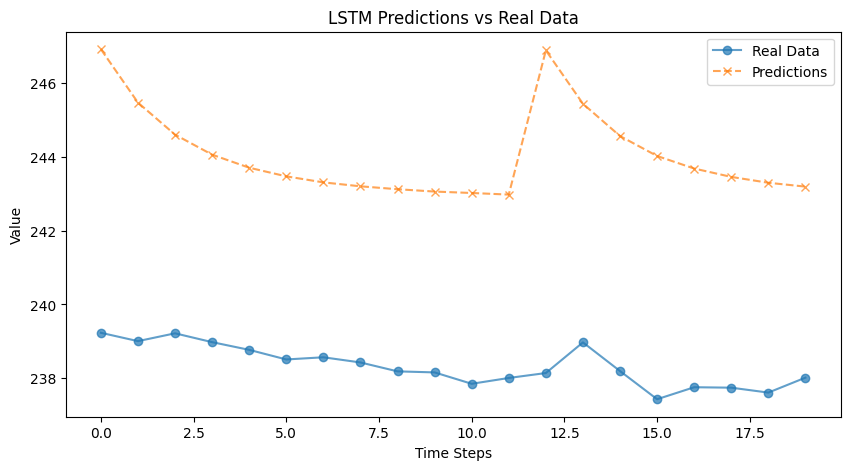

In [220]:
min_length = min(len(test_df), len(flt_preds))
real_data = test_df[:min_length].to_numpy().flatten() * train_std['O2_avg'] + train_mean['O2_avg']
flattened_predictions = flt_preds[:min_length] * train_std['O2_avg'] + train_mean['O2_avg']

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(real_data, label="Real Data", linestyle="-", marker="o", alpha=0.7)
plt.plot(flattened_predictions, label="Predictions", linestyle="--", marker="x", alpha=0.7)
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.title("LSTM Predictions vs Real Data")
plt.legend()
plt.show()